## 1. Project Background
Accurate information on forest cover is important for supporting forest conservation and management efforts. Traditional methods of determining forest cover such as ground-based surveys are very tedious, expensive and time consuming.

Advanced methods, such as remote sensing coupled with robust geographical information systems (GIS) present an opportunity for cost effective and large scale forest cover mapping. However they still rely on very simple classification algorithms and require experts to manually draw polygons over the various classes (Gachuhi & Kibui, 2024). Other advanced approaches to forest mapping involve using indices derived from satellite imagery such as the Normalised Difference Vegetative Index (NDVI), but this too is prone to inaccuracies because it is easily affected by conditions such as soil moisture and NDVI cannot differentiate between very similar classes such as a shrub and a forest (Cropin, 2021).

To counter these limitations, deep learning techniques can be used to automate the process of identifying forested areas from satellite images. One such technique is semantic segmentation which is a computer vision task that classifies each pixel in an input image into specific classes resulting in a dense pixel-wise feature map.

## 2. Data Loading & Preprocessing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random 
import cv2

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout,concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split

In [2]:
#define paths to the data on local drive
img_dir=r'C:\Users\Admin\Desktop\Capstone_project_research\images'
mask_dir=r'C:\Users\Admin\Desktop\Capstone_project_research\masks'

#define batch size-how many images will be taken at a time during training
batch_size=50

In [3]:
# load data using a generator for efficiency
def image_generator(image_dir, mask_dir, batch_size):


#create a list of paths for each image/mask
  image_filenames=sorted(os.listdir(img_dir))
  mask_filenames=sorted(os.listdir(mask_dir))


  while True:
    for i in range(0,len(image_filenames),batch_size):
      image_filepaths_batch=image_filenames[i:i+batch_size]
      masks_filepatch_batch=mask_filenames[i:i+batch_size]

      images=[]
      masks=[]

      #load each image/mask in the batch
      for image_name,mask_name in zip(image_filenames,mask_filenames):
          img_path=os.path.join(img_dir,image_name)
          img=tf.keras.preprocessing.image.load_img(img_path)  
          img=tf.keras.preprocessing.image.img_to_array(img)/255

          msk_path=os.path.join(mask_dir,mask_name)
          msk=tf.keras.preprocessing.image.load_img(msk_path, color_mode='grayscale')
          msk=tf.keras.preprocessing.image.img_to_array(msk)/255

          images.append(img)
          masks.append(msk)
      yield np.array(images), np.array(masks)

In [4]:
#for x in image_generator(img_dir,mask_dir,batch_size):
   # print(x)
#the function produces an array of the first 50 images

In [4]:
X_batch,y_batch=next(image_generator(img_dir,mask_dir,batch_size))

In [5]:
print(X_batch.shape)
print(y_batch.shape)

(5108, 256, 256, 3)
(5108, 256, 256, 1)


Image path: C:\Users\Admin\Desktop\Capstone_project_research\images\122178_sat_03.jpg
Mask path: C:\Users\Admin\Desktop\Capstone_project_research\masks\122178_mask_03.jpg


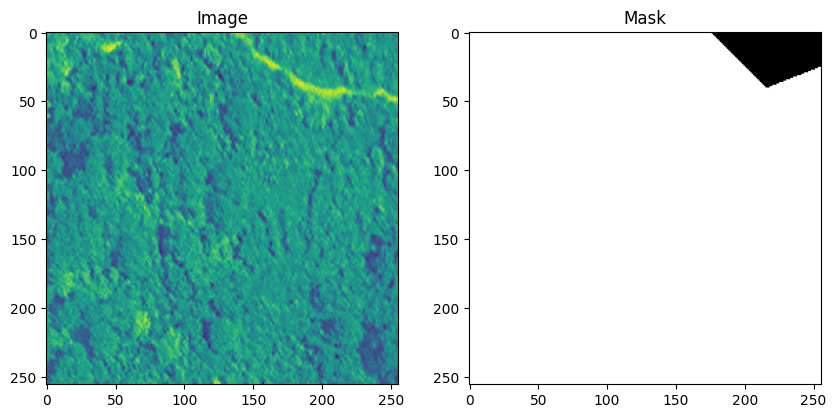

In [6]:

num_images=len(os.listdir(img_dir))
img_num = random.randint(0, num_images-1)

# Get the list of image and mask filenames
image_filenames=sorted(os.listdir(img_dir))
mask_filenames=sorted(os.listdir(mask_dir))

# Paths for the randomly selected image/masks pair
img_path = os.path.join(img_dir, image_filenames[img_num]) 
mask_path = os.path.join(mask_dir, mask_filenames[img_num])

# Print the paths for verification
print("Image path:", img_path)
print("Mask path:", mask_path)

# Load the image and mask
img_for_plot = cv2.imread(img_path, 0)
mask_for_plot = cv2.imread(mask_path, 0)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(img_for_plot, cmap='viridis')
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

## 3. Build the models

### 3.1 Fully Convolutional Network

In [7]:
def FCN(inputs):
    #encoder block
    conv1=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
    conv1=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv1)
    pool1=tf.keras.layers.MaxPooling2D((2,2))(conv1)

    conv2=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(pool1)
    conv2=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv2)
    pool2=tf.keras.layers.MaxPooling2D((2,2))(conv2)

    conv3=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(pool2)
    conv3=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv3)
    pool3=tf.keras.layers.MaxPooling2D((2,2))(conv3)

    conv4=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool3)
    conv4=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(conv4)
    pool4=tf.keras.layers.MaxPooling2D((2,2))(conv4)

    #decoder
    up5=tf.keras.layers.Conv2DTranspose(256,(2,2),strides=(2,2), padding='same')(pool4)
    conv5=tf.keras.layers.Conv2D(256,(3,3), activation='relu',padding='same')(up5)
    
    up6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2), padding='same')(conv5)
    conv6=tf.keras.layers.Conv2D(128,(3,3), activation='relu',padding='same')(up6)
  
    up7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(conv6)
    conv7=tf.keras.layers.Conv2D(64,(3,3), activation='relu',padding='same')(up7)
   
    up8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2), padding='same')(conv7)
    conv8=tf.keras.layers.Conv2D(32,(3,3), activation='relu',padding='same')(up8)
   

    output=tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(conv8)

    return output

In [8]:
#compile the model
inputs= tf.keras.Input(shape=(256,256,3))
outputs=FCN(inputs)
model=tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │       262,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 32)   │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,390,785 (9.12 MB)

 Trainable params: 2,390,785 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

Mental note: I have only 7 layers in my network-but the model.summary() outputs more than those? How come?

### 3.2 U-net model

In [9]:
def UNET (input):
    #contracting path
    conv1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(input)
    conv1=keras.layers.Dropout(0.1)(conv1)
    conv1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(conv1)
    pool1=tf.keras.layers.MaxPooling2D((2,2))(conv1)
    
    conv2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(pool1)
    conv2=keras.layers.Dropout(0.1)(conv2)
    conv2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv2)
    pool2=tf.keras.layers.MaxPooling2D((2,2))(conv2)
    
    conv3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(pool2)
    conv3=keras.layers.Dropout(0.1)(conv3)
    conv3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv3)
    pool3=tf.keras.layers.MaxPooling2D((2,2))(conv3)

    conv4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(pool3)
    conv4=keras.layers.Dropout(0.1)(conv4)
    conv4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv4)
    pool4=tf.keras.layers.MaxPooling2D((2,2))(conv4)
    
    #bottle neck layer
    conv5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool4)
    conv5=keras.layers.Dropout(0.1)(conv5)
    conv5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(conv5)
    

    #expanding path
    up6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2), padding='same')(conv5)
    up6=tf.keras.layers.concatenate([up6,conv4])
    conv6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(up6)
    conv6=keras.layers.Dropout(0.1)(conv6)
    conv6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv6)

    up7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(conv6)
    up7=tf.keras.layers.concatenate([up7,conv3])
    conv7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(up7)
    conv7=keras.layers.Dropout(0.1)(conv7)
    conv7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv7)

    up8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2), padding='same')(conv7)
    up8=tf.keras.layers.concatenate([up8,conv2])
    conv8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(up8)
    conv8=keras.layers.Dropout(0.1)(conv8)
    conv8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv8)

    up9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2), padding='same')(conv8)
    up9=tf.keras.layers.concatenate([up9,conv1])
    conv9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(up9)
    conv9=keras.layers.Dropout(0.1)(conv9)
    conv9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(conv9)

    output=tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(conv9)

    return output

In [10]:
#compile the model
inputs= tf.keras.Input(shape=(256,256,3))
outputs=UNET(inputs)
model_unet=tf.keras.Model(inputs=inputs, outputs=outputs)
model_unet.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model_unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d_13[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_20[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the models

#### Split data into train, validation and test sets

In [11]:
#split data into test and train
X_train, X_temp, y_train, y_temp = train_test_split(X_batch, y_batch, test_size=0.2, random_state=42)
X_val,X_test, y_val,y_test=train_test_split(X_temp,y_temp)

#### 4.1 Train the Fully Convolutional Network

In [12]:
early_stopper=EarlyStopping(monitor='val_loss',patience=5)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=early_stopper)             

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1546s 19s/step - accuracy: 0.6028 - loss: 0.6920 - val_accuracy: 0.5996 - val_loss: 0.6695
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2222s 27s/step - accuracy: 0.6178 - loss: 0.6591 - val_accuracy: 0.7006 - val_loss: 0.6131
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2213s 27s/step - accuracy: 0.7161 - loss: 0.5729 - val_accuracy: 0.7355 - val_loss: 0.5300
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2759s 34s/step - accuracy: 0.7561 - loss: 0.5169 - val_accuracy: 0.7534 - val_loss: 0.5137
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1720s 21s/step - accuracy: 0.7682 - loss: 0.4977 - val_accuracy: 0.7591 - val_loss: 0.5074
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2202s 27s/step - accuracy: 0.7619 - loss: 0.5138 - val_accuracy: 0.7546 - val_loss: 0.5249
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2086s 25s/step - accuracy: 0.7633 - loss: 0.5095 - val_accuracy: 0.7476 - val_loss: 0.5122
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2114s 26s/step - accuracy: 0.7738 - loss: 0.4875 - val_accu

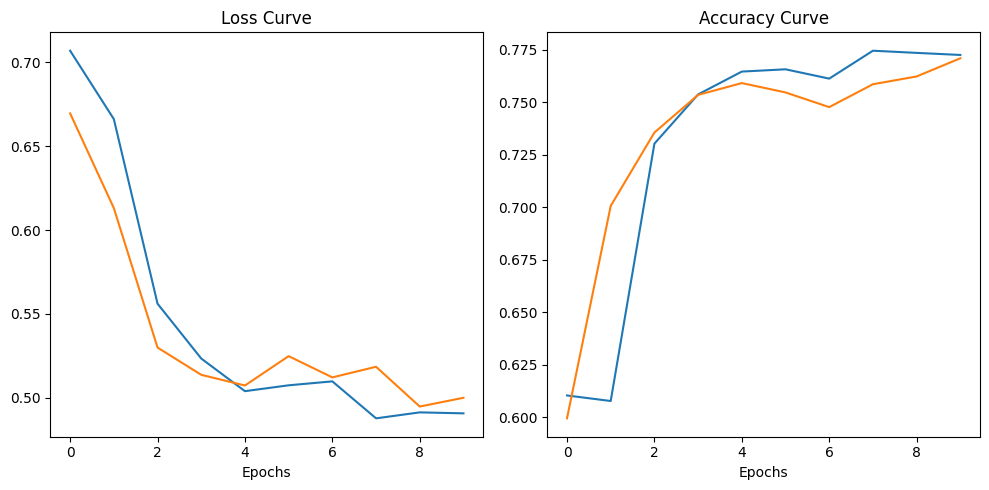

In [15]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(train_loss,label='Training loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.legend

plt.subplot(122)
plt.plot(train_accuracy,label='Training Accuracy')
plt.plot(val_accuracy,label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.legend

plt.tight_layout()
plt.show()

### Insights from model training
1. The validation loss is slightly higher than the training loss, which is expected because the model has not seen that data before, but could be a sign of slight overfitting
2. Again, the accuracy of the train dataset is higher that the validation dataset, but they are very close to each other after the 8th epoch

##### 4.1.1 Save the trained FCN model

In [16]:
model.save('fcn_model.keras')
from tensorflow.keras.models import load_model
trained_fcn_model=load_model('fcn_model.keras')
trained_fcn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │       262,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 32)   │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,357 (27.36 MB)

 Trainable params: 2,390,785 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,781,572 (18.24 MB)

#### 4.2 Train the U-net model

In [17]:
early_stopper=EarlyStopping(monitor='val_loss',patience=5)

history = model_unet.fit(
    X_train, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=early_stopper)  

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6043 - loss: 0.6617

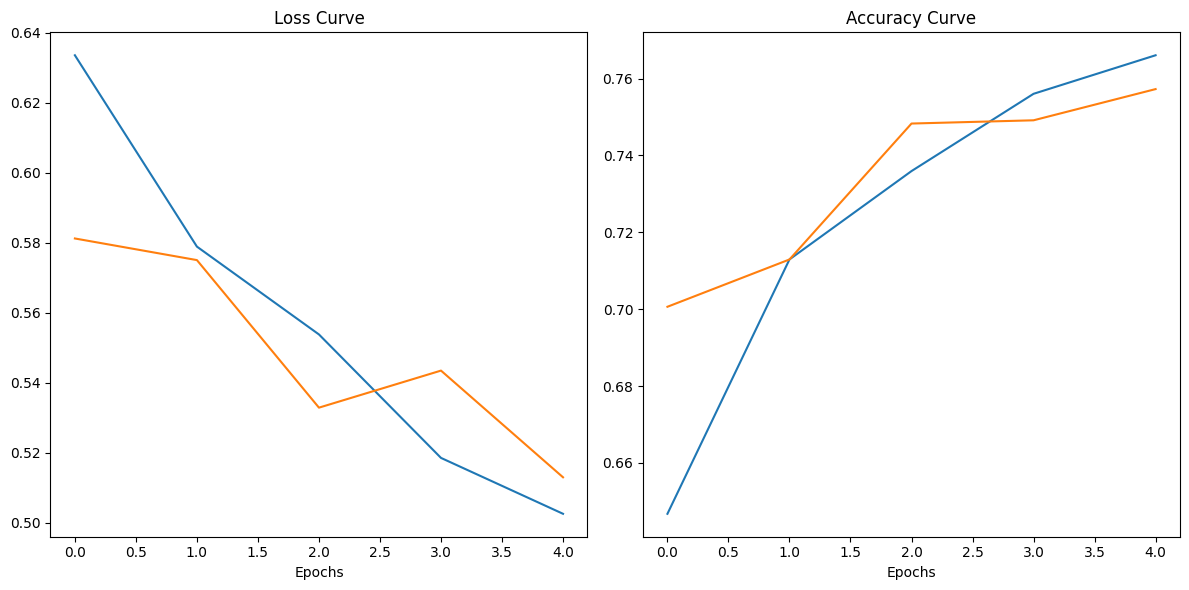

In [104]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(train_loss,label='Training loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.legend

plt.subplot(122)
plt.plot(train_accuracy,label='Training Accuracy')
plt.plot(val_accuracy,label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.legend

plt.tight_layout()
plt.show()

### Insights from model training: Unet
1.
2.

##### 4.2.2 Save the trained U-net model

In [16]:
model_unet.save('unet_model.keras')
from tensorflow.keras.models import load_model
trained_unet_model=load_model('unet_model.keras')
#trained_unet_model.summary()

## 5. HyperParameter Tuning using Keras Tuner

In [9]:
!pip install keras-tuner

In [10]:
from kerastuner.tuners import RandomSearch

C:\Users\Admin\AppData\Local\Temp\ipykernel_144\2610907151.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [11]:
def hp_unet (hp):
    inputs= keras.Input(shape=(256, 256, 3))

    # list the hyperparameters to be tuned
    activation = hp.Choice('activation', ['relu', 'leaky_relu'])
    learning_rate=hp.Choice('learning_rate',['1e-2','1e-3','1e-4','1e-5'])

    #contracting path
    conv1=tf.keras.layers.Conv2D(16,(3,3),activation=activation,padding='same')(inputs)
    conv1=keras.layers.Dropout(0.1)(conv1)
    conv1=tf.keras.layers.Conv2D(16,(3,3),activation=activation,padding='same')(conv1)
    pool1=tf.keras.layers.MaxPooling2D((2,2))(conv1)
    
    conv2=tf.keras.layers.Conv2D(32,(3,3),activation=activation,padding='same')(pool1)
    conv2=keras.layers.Dropout(0.1)(conv2)
    conv2=tf.keras.layers.Conv2D(32,(3,3),activation=activation,padding='same')(conv2)
    pool2=tf.keras.layers.MaxPooling2D((2,2))(conv2)
    
    conv3=tf.keras.layers.Conv2D(64,(3,3),activation=activation,padding='same')(pool2)
    conv3=keras.layers.Dropout(0.1)(conv3)
    conv3=tf.keras.layers.Conv2D(64,(3,3),activation=activation,padding='same')(conv3)
    pool3=tf.keras.layers.MaxPooling2D((2,2))(conv3)

    conv4=tf.keras.layers.Conv2D(128,(3,3),activation=activation,padding='same')(pool3)
    conv4=keras.layers.Dropout(0.1)(conv4)
    conv4=tf.keras.layers.Conv2D(128,(3,3),activation=activation,padding='same')(conv4)
    pool4=tf.keras.layers.MaxPooling2D((2,2))(conv4)
    
    #bottle neck layer
    conv5=tf.keras.layers.Conv2D(256,(3,3),activation=activation,padding='same')(pool4)
    conv5=keras.layers.Dropout(0.1)(conv5)
    conv5=tf.keras.layers.Conv2D(256,(3,3),activation=activation,padding='same')(conv5)
    

    #expanding path
    up6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2), padding='same')(conv5)
    up6=tf.keras.layers.concatenate([up6,conv4])
    conv6=tf.keras.layers.Conv2D(128,(3,3),activation=activation,padding='same')(up6)
    conv6=keras.layers.Dropout(0.1)(conv6)
    conv6=tf.keras.layers.Conv2D(128,(3,3),activation=activation,padding='same')(conv6)

    up7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(conv6)
    up7=tf.keras.layers.concatenate([up7,conv3])
    conv7=tf.keras.layers.Conv2D(64,(3,3),activation=activation,padding='same')(up7)
    conv7=keras.layers.Dropout(0.1)(conv7)
    conv7=tf.keras.layers.Conv2D(64,(3,3),activation=activation,padding='same')(conv7)

    up8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2), padding='same')(conv7)
    up8=tf.keras.layers.concatenate([up8,conv2])
    conv8=tf.keras.layers.Conv2D(32,(3,3),activation=activation,padding='same')(up8)
    conv8=keras.layers.Dropout(0.1)(conv8)
    conv8=tf.keras.layers.Conv2D(32,(3,3),activation=activation,padding='same')(conv8)

    up9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2), padding='same')(conv8)
    up9=tf.keras.layers.concatenate([up9,conv1])
    conv9=tf.keras.layers.Conv2D(16,(3,3),activation=activation,padding='same')(up9)
    conv9=keras.layers.Dropout(0.1)(conv9)
    conv9=tf.keras.layers.Conv2D(16,(3,3),activation=activation,padding='same')(conv9)

    output=tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(conv9)
    tuned_unet=tf.keras.Model(inputs=inputs, outputs=output)
    
    tuned_unet.compile(optimizer=Adam(learning_rate=float(learning_rate)), loss='binary_crossentropy',metrics=['accuracy'])

    return tuned_unet

In [14]:
tuner = RandomSearch(
    hp_unet,  
    objective='val_accuracy',  
    max_trials=5,  
    directory=r'C:\Users\Admin\Desktop\Capstone_project_research',  
    project_name='unet_tuner'  
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
learning_rate (Choice)
{'default': '1e-2', 'conditions': [], 'values': ['1e-2', '1e-3', '1e-4', '1e-5'], 'ordered': False}


In [16]:
tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 5 Complete [01h 11m 11s]
val_accuracy: 0.7434754371643066

Best val_accuracy So Far: 0.7434754371643066
Total elapsed time: 10h 22m 53s


In [18]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f'Best Learning rate: {best_hps.get('learning_rate')}')
print(f'Best activation function: {best_hps.get('activation')}')


Best Learning rate: 1e-3
Best activation function: leaky_relu


#### Train the model on the best hyperparameters

In [19]:
# Build the model with the optimal hyperparameters
# train the model.
tuned_model = tuner.hypermodel.build(best_hps)
tuned_model.fit(X_train, y_train, 
          validation_data= (X_val,y_val), 
          epochs= 5,
           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)])

Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - accuracy: 0.6447 - loss: 0.6342 - val_accuracy: 0.6873 - val_loss: 0.6027
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 815s 6s/step - accuracy: 0.7110 - loss: 0.5819 - val_accuracy: 0.6735 - val_loss: 0.6064
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 795s 6s/step - accuracy: 0.7191 - loss: 0.5688 - val_accuracy: 0.7160 - val_loss: 0.5793
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 796s 6s/step - accuracy: 0.7290 - loss: 0.5602 - val_accuracy: 0.7152 - val_loss: 0.5555
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 821s 6s/step - accuracy: 0.7431 - loss: 0.5414 - val_accuracy: 0.7375 - val_loss: 0.5390


#### Save the hypertuned model

In [20]:
tuned_model.save('hypertuned_unet_model.keras')

## 6. Model Testing & Evaluation

In [10]:
#load the optmized model
from tensorflow.keras.models import load_model
hypertuned_unet_model=load_model('hypertuned_unet_model.keras')


####  6.1 Evaluation Metric: Acccuracy

In [22]:
evaluation=hypertuned_unet_model.evaluate(X_test,y_test)
print(f'Loss: {evaluation[0]}')
print(f'Accuracy: {evaluation[1]}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7428 - loss: 0.5338
Loss: 0.5349696278572083
Accuracy: 0.7384024262428284


#### 6.2 Evaluation Metric: Intersection over Union (IoU)

In [64]:
predicted_masks=hypertuned_unet_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [65]:
def calculate_iou(y_true, y_pred):
    # Flatten the arrays to handle multi-dimensional inputs
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate intersection and union
    intersection = np.sum(np.logical_and(y_true_flat, y_pred_flat))
    union = np.sum(np.logical_or(y_true_flat, y_pred_flat))
    
    # Calculate IoU
    iou = intersection / union
    return iou

In [77]:
# Assuming the output is a probability map and you want binary masks
predicted_masks_binary = (predicted_masks> 0.4).astype(np.uint8)

# Calculate IoU for each image
ious = []
for i in range(len(y_test)):
    iou = calculate_iou(y_test[i], predicted_masks_binary[i])
    ious.append(iou)

# Compute average IoU
average_iou = np.mean(ious)
print("Average IoU:", average_iou)


Average IoU: 0.6239940077497391


# 7. Error Analysis

Image path: C:\Users\Admin\Desktop\Capstone_project_research\images\338661_sat_75.jpg
Mask path: C:\Users\Admin\Desktop\Capstone_project_research\masks\338661_mask_75.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


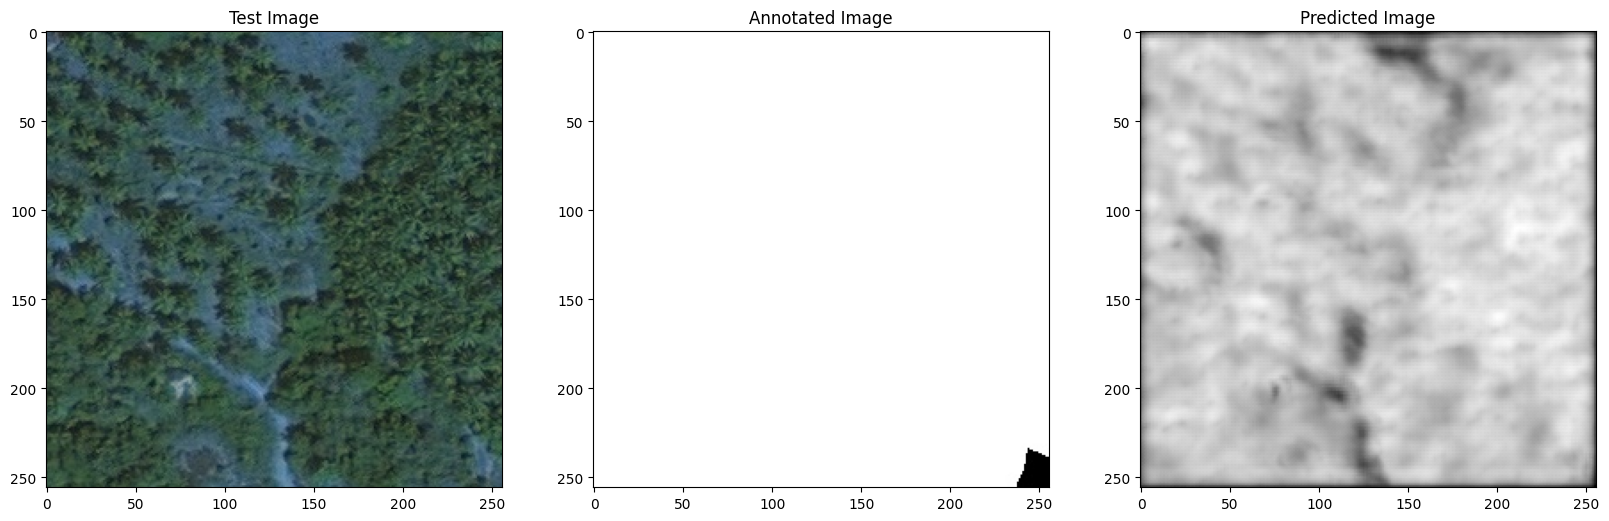

In [83]:
num_images=len(os.listdir(img_dir))
randomizer = random.randint(0, num_images-1)

# Get the list of image and mask filenames
image_filenames=sorted(os.listdir(img_dir))
mask_filenames=sorted(os.listdir(mask_dir))

# Paths for the randomly selected image/masks pair
test_img_path = os.path.join(img_dir, image_filenames[randomizer]) 
mask_img_path = os.path.join(mask_dir, mask_filenames[randomizer])

# Print the paths for verification
print("Image path:", test_img_path)
print("Mask path:", mask_img_path)

# Load the image and mask
test_img = cv2.imread(test_img_path)/255
mask_img = cv2.imread(mask_img_path)/255

# Adding batch dimension to the test image before prediction
test_img_batch = np.expand_dims(test_img, axis=0)

# Predicting the mask for the test image
predicted_img = hypertuned_unet_model.predict(test_img_batch)

# Removing the batch dimension from the predicted image
predicted_img = np.squeeze(predicted_img)


# Plotting
plt.figure(figsize=(20,18))

plt.subplot(231)
plt.imshow(test_img)
plt.title('Test Image')

plt.subplot(232)
plt.imshow(mask_img, cmap='gray')
plt.title('Annotated Image')

plt.subplot(233)
plt.imshow(predicted_img, cmap='gray')
plt.title('Predicted Image')

plt.show()
